# Community VIX Index
- 미국 주식 갤러리 스크래핑 및 단어 시각화

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

from konlpy.tag import Okt
from nltk.corpus import stopwords
import re

from itertools import chain
from collections import Counter
from datetime import datetime, date
from wordcloud import WordCloud
import investpy as inv

In [ ]:
headers = {
    "Connection" : "keep-alive",
    "Cache-Control" : "max-age=0",
    "sec-ch-ua-mobile" : "?0",
    "DNT" : "1",
    "Upgrade-Insecure-Requests" : "1",
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36",
    "Accept" : "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Sec-Fetch-Site" : "none",
    "Sec-Fetch-Mode" : "navigate",
    "Sec-Fetch-User" : "?1",
    "Sec-Fetch-Dest" : "document",
    "Accept-Encoding" : "gzip, deflate, br",
    "Accept-Language" : "ko-KR,ko;q=0.9"
    }

## Scraping

In [ ]:
posts = {'title':list(),'subject':list(),'date':list()}

for page in range(1,1000):
    url = f'https://gall.dcinside.com/mgallery/board/lists/?id=stockus&page={page}'
    response = requests.get(url, headers=headers)
    source = BeautifulSoup(response.content, 'html.parser')

    gall_list = source.find('div',{'class':'gall_listwrap list'})
    post_list = gall_list.find_all('tr',{'class':'us-post'})
    posts['title'] += [post.find('td',{'class':'gall_tit'}).get_text() for post in post_list]
    posts['subject'] += [post.find('td',{'class':'gall_subject'}).get_text() for post in post_list]
    posts['date'] += [post.find('td',{'class':'gall_date'}).attrs['title'] for post in post_list]

In [ ]:
df = pd.DataFrame(posts)
df.head()

,title,subject,date
0,\n신고/건의 글\n[249],공지,2022-05-27 23:56:55
1,\n주식 분할 스케줄\n[6],공지,2022-07-02 06:48:55
2,\n주식 정보사이트 정리\n[7],공지,2022-06-21 20:48:39
3,\nBULZ (블즈) 투자자들 읽어야할 PDF 파일\n[13],공지,2022-06-15 13:34:25
4,\n주요 ETF/ETN 리스트\n[145],공지,2021-10-10 15:54:35


## Preprocessing

In [ ]:
df = df[df['subject'] != '공지'].reset_index().drop(['index'],axis=1)
df['title'] = df['title'].apply(lambda x: re.search('\n([^\n]*)\n', x)[0].strip())
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df.head()

,title,subject,date
0,신입 안 뽑는 이유 있음,일반,2022-07-13 10:41:30
1,진짜 예적금이 최고가 될줄은,일반,2022-07-13 10:41:29
2,부동산 진짜 개 ㅈ된 이유 feat. 변동금리,일반,2022-07-13 10:41:01
3,올해부터 취업하는 애들 좆됐네 ㄹㅇ..,일반,2022-07-13 10:40:53
4,3d초특급 기피이유,일반,2022-07-13 10:40:14


In [ ]:
stop_words = stopwords.words('korean')

def ko_tokenize(sequence: str):
    okt = Okt()
    tokenized = okt.morphs(sequence)
    return [word for word in tokenized if word not in stop_words]

df['title'] = df['title'].apply(lambda x: re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',' ',x))
df['title'] = df['title'].apply(lambda x: re.sub('^ +','',x))

df['token'] = [ko_tokenize(title) for title in df['title'].tolist()]
df.head()

,title,subject,date,token
0,신입 안 뽑는 이유 있음,일반,2022-07-13 10:41:30,"[신입, 안, 뽑는, 이유, 있음]"
1,진짜 예적금이 최고가 될줄은,일반,2022-07-13 10:41:29,"[진짜, 적금, 최고, 될줄은]"
2,부동산 진짜 개 ㅈ된 이유 변동금리,일반,2022-07-13 10:41:01,"[부동산, 진짜, 개, ㅈ, 된, 이유, 변동, 금리]"
3,올해부터 취업하는 애들 좆됐네 ㄹㅇ,일반,2022-07-13 10:40:53,"[올해, 취업, 하는, 애, 좆, 됐네, ㄹㅇ]"
4,초특급 기피이유,일반,2022-07-13 10:40:14,"[초, 특급, 기피, 이유]"


In [ ]:
df.tail()

,title,subject,date,token
49814,맥도날드 빅스세트맛있냐,일반,2022-07-02 10:15:06,"[맥도날드, 빅스, 세트, 맛있냐]"
49815,난 유동원 믿고 주식 시작했는데,일반,2022-07-02 10:14:57,"[난, 유동, 원, 믿고, 주식, 시작, 했는데]"
49816,아 어제 못먹은게 왜이리 아깝지,일반,2022-07-02 10:14:08,"[어제, 못, 먹은게, 이리, 아깝지]"
49817,아니 궁금해서 그런데,일반,2022-07-02 10:14:02,[궁금해서]
49818,주식으로 퍼다 죽고싶다 씨드크다,일반,2022-07-02 10:13:43,"[주식, 퍼다, 죽고싶다, 씨드, 크다]"


In [ ]:
df.to_csv('stockus_0712_to_0702.csv',index=False)

## Compare with NASDAQ Index

In [ ]:
nasdaq = inv.get_index_historical_data(index='Nasdaq', country='United States', from_date='01/07/2022', to_date='13/07/2022')
nasdaq.sort_index(ascending=False, inplace=True)
nasdaq

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-07-12,11420.02,11482.71,11207.08,11264.73,833053120,USD
2022-07-11,11524.74,11540.42,11348.85,11372.60,840546752,USD
2022-07-08,11503.61,11689.70,11479.77,11635.31,820689984,USD
2022-07-07,11422.60,11644.47,11412.88,11621.35,916259968,USD
2022-07-06,11337.90,11443.14,11250.32,11361.85,933390016,USD
2022-07-05,10964.18,11323.89,10911.45,11322.24,1065360000,USD
2022-07-01,11006.83,11132.55,10922.71,11127.84,930710016,USD


In [ ]:
nasdaq['Diff'] = np.diff(nasdaq['Close'].tolist()+[0.])*-1
nasdaq

,Open,High,Low,Close,Volume,Currency,Diff
Date,,,,,,,
2022-07-12,11420.02,11482.71,11207.08,11264.73,833053120,USD,-107.87
2022-07-11,11524.74,11540.42,11348.85,11372.60,840546752,USD,-262.71
2022-07-08,11503.61,11689.70,11479.77,11635.31,820689984,USD,13.96
2022-07-07,11422.60,11644.47,11412.88,11621.35,916259968,USD,259.50
2022-07-06,11337.90,11443.14,11250.32,11361.85,933390016,USD,39.61
2022-07-05,10964.18,11323.89,10911.45,11322.24,1065360000,USD,194.40
2022-07-01,11006.83,11132.55,10922.71,11127.84,930710016,USD,11127.84


### 일일 포스트 추출
- 금일 17:00 부터 익일 09:00 사이 올라온 포스트

In [ ]:
def daily_posts(df: pd.DataFrame, year: int, month: int, day: int) -> pd.DataFrame:
    start = datetime(year, month, day, 17)
    end = datetime(year, month, day+1, 9)
    daily_df = df[(df['date'] > start) & (df['date'] < end)]
    return daily_df.reset_index().drop(['index'],axis=1)

### 종가 기준 떡상한 날(2022-07-07)의 단어 분포
- 상대적으로 손실이 많은 숏(매도자)를 언급하는 표현이 많음

In [ ]:
user_word_list = sorted(chain.from_iterable(daily_posts(df, 2022, 7, 7)['token'].tolist()))
user_word_list = [word for word in user_word_list if word not in {'오늘','보다','아니다','ㅋㅋ'}]
user_word_dict = Counter(user_word_list)
user_word_dict.most_common(5)

[('숏', 167), ('지금', 164), ('안', 142), ('나스닥', 131), ('유가', 122)]

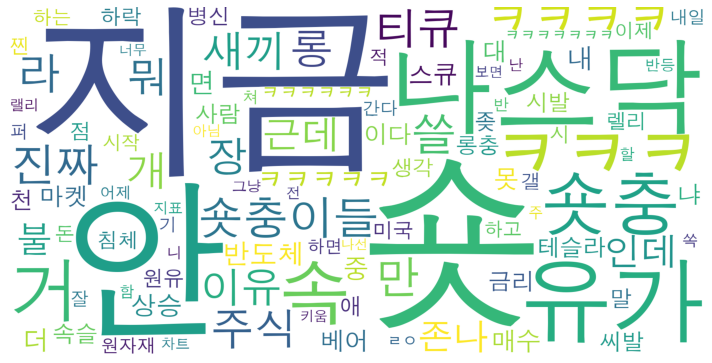

In [ ]:


user_word_cloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                        max_words=100, width=2000, height=1000,
                        prefer_horizontal= 1.0, background_color='white')
user_word_cloud.generate_from_frequencies(user_word_dict)

plt.figure(figsize=(10,10))
plt.imshow(user_word_cloud)
plt.axis('off')
plt.tight_layout()
plt.show()

### 종가 기준 떡락한 날(2022-07-11)의 단어 분포
- 상대적으로 손실이 많은 롱(매수자)를 언급하는 표현이 많음

In [ ]:
user_word_list = sorted(chain.from_iterable(daily_posts(df, 2022, 7, 11)['token'].tolist()))
user_word_list = [word for word in user_word_list if word not in {'오늘','보다','아니다','ㅋㅋ'}]
user_word_dict = Counter(user_word_list)
user_word_dict.most_common(5)

[('말', 197), ('테슬라', 155), ('미국', 141), ('ㅋㅋㅋ', 135), ('롱충', 128)]

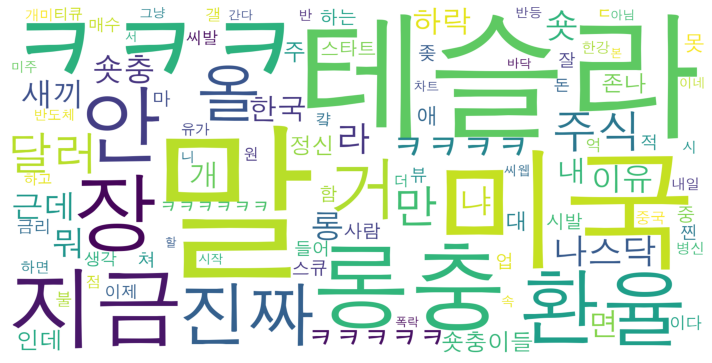

In [ ]:
user_word_cloud = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                        max_words=100, width=2000, height=1000,
                        prefer_horizontal= 1.0, background_color='white')
user_word_cloud.generate_from_frequencies(user_word_dict)

plt.figure(figsize=(10,10))
plt.imshow(user_word_cloud)
plt.axis('off')
plt.tight_layout()
plt.show()